In [1]:
import ingestor, modeller, fitter
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.style.use('seaborn-notebook')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['figure.figsize'] = [15, 10]

In [3]:
from importlib import reload

reload(fitter)
reload(modeller)
reload(ingestor)

<module 'ingestor' from '/media/dwu402/Data/wrap-mad/ingestor.py'>

In [4]:
context = ingestor.Context("runs/minimal3.3.run")

In [5]:
solver = fitter.Fitter(context)

In [6]:
for rhoi in np.logspace(-6, 6, num=49):
    solver.solve(rhoi)
    solver.problems[0].initial_guess = solver.solutions[str(rhoi)][-1].x

In [7]:
solver.write("out/33solutions.out")

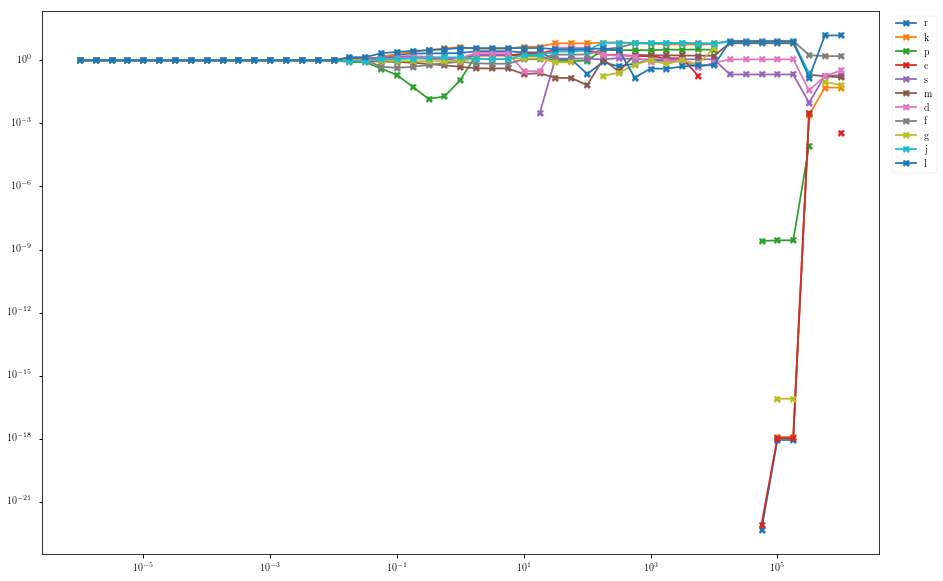

In [8]:
rhos = [float(rho) for rho in solver.solutions.keys()]
vals = [val[0].x for val in solver.solutions.values()]
plt.plot(rhos, vals, 'X-')
plt.legend("rkpcsmdfgjl", loc="best", bbox_to_anchor=(1.01, 1))
plt.xscale("log")
plt.yscale("log", nonposy="mask")

Text(0.5, 1.0, 'Outer Objective Function Values by Algo Parameter')

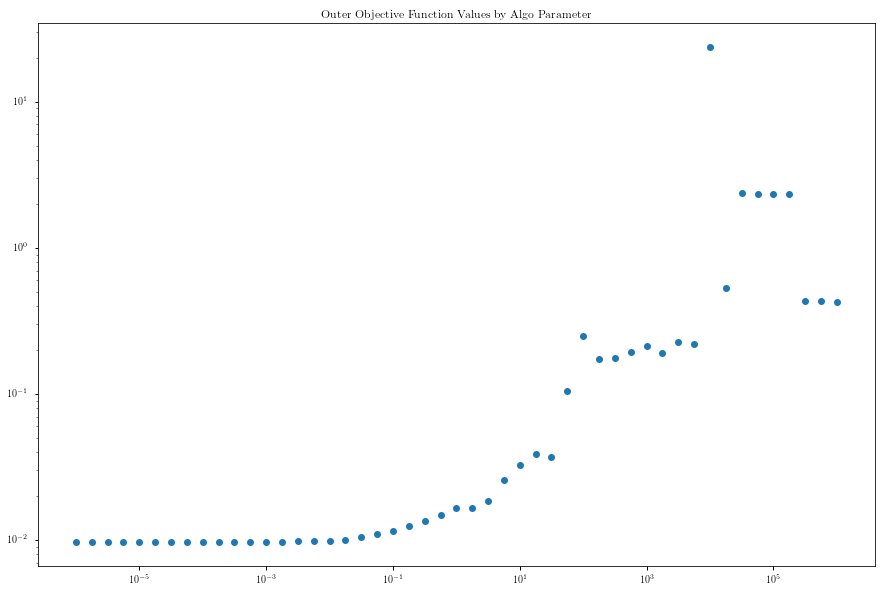

In [9]:
outer_objective_values = np.array([[float(rho), val[0].fun] for rho, val in solver.solutions.items()])
plt.loglog(*outer_objective_values.T, 'o')
plt.title("Outer Objective Function Values by Algo Parameter")

Text(0, 0.5, 'Number')

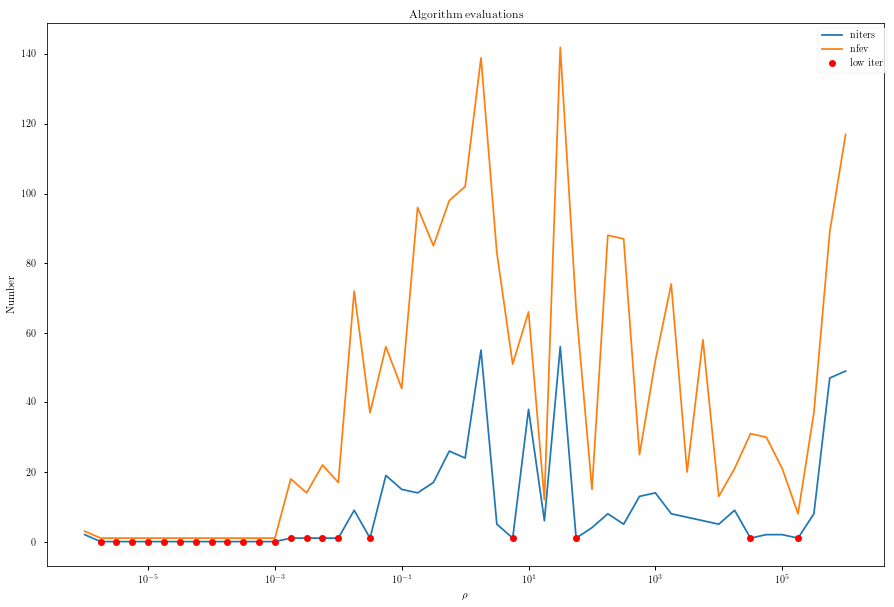

In [10]:
iters_list = np.array([[float(key), value[0].nit] for key, value in solver.solutions.items()])
fevs_list = np.array([[float(key), value[0].nfev] for key, value in solver.solutions.items()])
plt.semilogx(*iters_list.T, *fevs_list.T)

low_iters = np.array([[k,v] for k,v in iters_list if v < 2])
plt.plot(*low_iters.T, 'ro')

plt.legend(["niters", "nfev", "low iter"], 
           loc="best", bbox_to_anchor=(1.01, 1))
plt.title("Algorithm evaluations")
plt.xlabel(r"$\rho$")
plt.ylabel("Number")

In [11]:
def tokey(rho, ps):
    return f"{'y'.join(map(str,ps))}r{rho}"
getx = fitter.ca.Function("getx", [model.ts, *model.cs], model.xs)
    

NameError: name 'model' is not defined

In [ ]:
target_rho = 8.709635899560814e-06
c_end = solver.problems[0].cache.results[tokey(target_rho, solver.solutions[str(target_rho)][0].x)].x

xs_end = np.array([np.array(i) for i in getx(model.observation_times, 
                                         *fitter.argsplit(c_end, 
                                                          3)
                                        )])

xscale = 100000
plt.plot(model.observation_times, np.hstack([xs_end[0]/xscale, xs_end[2]]),
         context.datasets[0]['t'], context.datasets[0]['x']/xscale, 'o',
         context.datasets[0]['t'], context.datasets[0]['z'], 'o')
plt.legend(list("xz") + ["x (data)", "z (data)"], loc="best", bbox_to_anchor=(1.01, 1))
plt.xlabel("time, t")

In [ ]:
spline_dfield = np.array([context.model(t, xs_end[:,i], solver.solutions[str(target_rho)][0].x) 
                 for i,t in enumerate(model.observation_times)])

spline_dfield = spline_dfield.reshape(spline_dfield.shape[:2])

plt.plot(xs_end[0], xs_end[2], 'o-')
plt.plot(context.datasets[0]['x'], context.datasets[0]['z'], 'o--', alpha=0.65)
plt.quiver(xs_end[0], xs_end[2], spline_dfield[:,0], spline_dfield[:,2], 
           scale=None, angles='xy', headwidth=3, headlength=4.5, headaxislength=4, width=0.0025)
plt.title(f"Gradients on Spline, $\\rho$ = {target_rho} (Data superimposed)")
plt.xlabel("x")
plt.ylabel("z")
plt.legend(["Spline", "Data", "Gradients"])

In [ ]:
plt.plot(xs_end[0], xs_end[1], 'o-')
plt.quiver(xs_end[0], xs_end[1], spline_dfield[:,0], spline_dfield[:,1], 
           scale=None, angles='xy', headwidth=3, headlength=4.5, headaxislength=4, width=0.0025)
plt.title(f"Gradients on Spline, $\\rho$ = {target_rho}")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(["Spline", "Gradients"])

In [ ]:
inner_objective_values = np.array([[r, solver.problems[0].cache.results[tokey(r, v)].fun] for r,v in zip(rhos, vals)])
dfield = np.hstack([np.array(rhos).reshape(-1,1), 
                    ((inner_objective_values - outer_objective_values)[:,1] / rhos).reshape(-1,1)])


In [ ]:
plt.loglog(*dfield.T)
plt.xlabel(r"$\rho$")
plt.ylabel("Diff Field")

In [ ]:
plt.loglog(outer_objective_values[:,1], dfield[:,1], 'o--', linewidth=0.25)
plt.xlabel("Outer Objective (Data Fit)")
plt.ylabel("Diff Field")

In [ ]:
from scipy import interpolate
smooth_outer = interpolate.UnivariateSpline(np.log(rhos), np.log(outer_objective_values[:,1]), s=3, k=4)
souter = np.exp(smooth_outer(np.log(rhos)))
smooth_dfield = interpolate.UnivariateSpline(np.log(rhos), np.log(dfield[:,1]), s=10, k=4)
sfield =  np.exp(smooth_dfield(np.log(rhos)))

fig, axs = plt.subplots(ncols=2)
axs[0].loglog(rhos, souter, rhos, outer_objective_values[:,1], 'o')
axs[0].set_title("Outer Objective")
axs[1].loglog(rhos, sfield, rhos, dfield[:,1], 'o')
axs[1].set_title("Gradient Field")

In [ ]:
plt.loglog(souter, sfield, '*--', outer_objective_values[:,1], dfield[:,1], 'o--')
plt.title("Smoothed vs Non-Smoothed L-Curve")
plt.xlabel(r"Outer Objective Function $||y-{\Phi}c||$")
plt.ylabel(r"Vector Field Discrepancy $||D({\Phi}c) - f({\Phi}c; \theta)||$")
plt.legend(["Smoothed", "Non-Smoothed"])

In [ ]:
rhos_log_finer = np.linspace(np.log10(rhos[0]), np.log10(rhos[-1]), len(rhos)*5)

curvs = []

sx = smooth_outer(rhos_log_finer)
sy = smooth_dfield(rhos_log_finer)

for idx in range(1, len(rhos_log_finer)-1):
    xs = sx[idx-1:idx+2]
    ys = sy[idx-1:idx+2]
    ps = np.vstack([xs,ys]).T
    curvs.append(2*np.abs(np.cross(ps[1] - ps[0], ps[2]-ps[1]))/(
            np.linalg.norm(ps[0]-ps[1])*np.linalg.norm(ps[1]-ps[2])*np.linalg.norm(ps[2]-ps[0])))

plt.plot(rhos_log_finer[1:-1], np.array(curvs), 'o-')
plt.title("L-Curve Curvature Plot (via Menger Curvature)")
plt.xlabel(r"$\log_{10}(\rho)$")
plt.ylabel(r"$\kappa$")

In [ ]:
print(10 ** rhos_log_finer[np.argmax(curvs) + 1])

In [ ]:
# generate a crude correlation plot

import pandas as pd

results = pd.DataFrame({r"$\rho$": np.log(rhos)})
for idx, name in enumerate("rkpcsmdfgjl"):
    results[name] = [v[idx] for v in vals]
    

In [ ]:
plt.imshow(np.abs(results.corr()))
plt.colorbar()
plt.xticks(range(12), [r"$\rho$"] + list("rkpcsmdfgjl"))
plt.yticks(range(12), [r"$\rho$"] + list("rkpcsmdfgjl"))
plt.grid(False)

In [ ]:
ax = pd.plotting.scatter_matrix(results)
for a in ax.flatten():
    a.grid(False)

In [ ]:
rhos